In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [2]:
START_DATE = date(2000, 1, 1)
END_DATE = date(2023, 1, 31)

In [3]:
def read_yahoo_csv(filepath):
    df = pd.read_csv(filepath)[["Date", "Adj Close"]]
    df["Date"] = pd.to_datetime(df["Date"])

    column_name = ".".join(os.path.basename(filepath).split(".")[:-1])

    df.rename(columns = {"Adj Close": column_name}, inplace = True)
    return df

def read_yahoo_folder(folderpath, start, end):
    df = pd.DataFrame({'Date': pd.date_range(start, end, freq = 'D')})

    with os.scandir(folderpath) as entries:
        for entry in entries:
            df = df.merge(read_yahoo_csv(entry), on = "Date", how = "left")

    df.set_index("Date", inplace = True)
    return df

Data downloaded manually from the Yahoo Finance website.

In [7]:
etf_df = read_yahoo_folder("data/etfs/", START_DATE, END_DATE)
exchange_rates_df = read_yahoo_folder("data/exchange-rates/", START_DATE, END_DATE)

[Text(0.5, 1.0, 'ETF prices in original currencies'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price')]

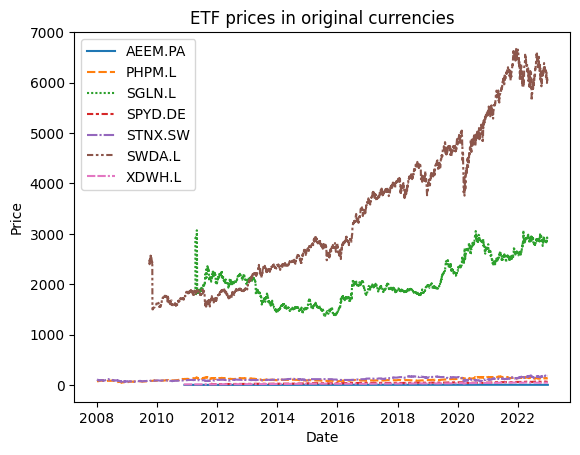

In [8]:
plot = sns.lineplot(data = etf_df)
plot.set(
    title = "ETF prices in original currencies",
    xlabel = "Date",
    ylabel = "Price")

[Text(0.5, 1.0, 'Exchange rates to PLN'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price of currency in PLN')]

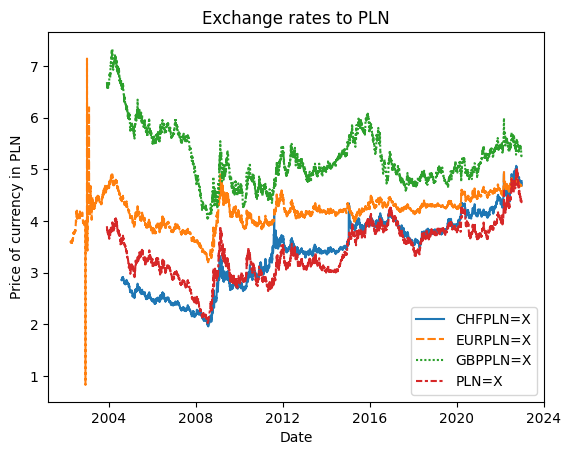

In [9]:
plot = sns.lineplot(data = exchange_rates_df)
plot.set(
    title = "Exchange rates to PLN",
    xlabel = "Date",
    ylabel = "Price of currency in PLN")

There is something weird going on with the EUR to PLN plot around 2002-2003, but let's ignore this for now. This period will fall out of the analysis anyways.

Keep in mind that the weirdly labeled `PLN=X` item stands for the USD to PLN exchange rate. The name comes from the label on the Yahoo Finance website.

This is not very useful just yet. Let's bring all values to PLN first. Note that Yahoo Finance presents some ETF's values in fractions.

In [40]:
etf_currencies = {
    "SGLN.L": ["GBPPLN=X", 0.01],
    "STNX.SW": ["CHFPLN=X", 1],
    "SWDA.L": ["GBPPLN=X", 0.01],
    "PHPM.L": ["PLN=X", 1],
    "SPYD.DE": ["EURPLN=X", 1],
    "AEEM.PA": ["EURPLN=X", 1],
    "XDWH.L": ["PLN=X", 1],
}

for column_name in etf_df.columns:
    etf_df[column_name] = etf_df[column_name] * exchange_rates_df[etf_currencies[column_name][0]] * etf_currencies[column_name][1]

Now, let's remove rows where the data is not full, so that all series start from the same point in time.

In [41]:
etf_df.dropna(inplace = True)

 Also, let's standarise the output, to make it easier to see differences in value. Before we do that, let's write down the latest prices.

In [42]:
latest_prices = get_latest_prices(etf_df)

etf_df = etf_df.div(etf_df.iloc[0] / 100)

In [43]:
latest_prices

PHPM.L     586.651109
SGLN.L     152.883882
SPYD.DE    302.034633
STNX.SW    854.922003
SWDA.L     319.144446
Name: 2022-12-23 00:00:00, dtype: float64

In [44]:
etf_df

,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L
Date,,,,,
2011-10-14,100.000000,100.000000,100.000000,100.000000,100.000000
2011-10-17,99.424854,100.311243,99.948786,100.326435,99.247750
2011-10-18,99.193810,100.218232,101.354843,102.080533,100.849047
2011-10-19,99.778431,99.487012,100.938815,103.302874,101.127185
2011-10-20,96.689167,97.927457,100.452838,101.673715,100.003301
...,...,...,...,...,...
2022-12-19,144.741134,148.138956,380.341403,264.130341,386.204800
2022-12-20,147.663010,150.205653,377.569842,263.535363,384.796731
2022-12-21,146.104063,150.683401,383.493156,268.213853,392.060799


[Text(0.5, 1.0, 'Portfolio components history in standardized prices'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Relative value in PLN')]

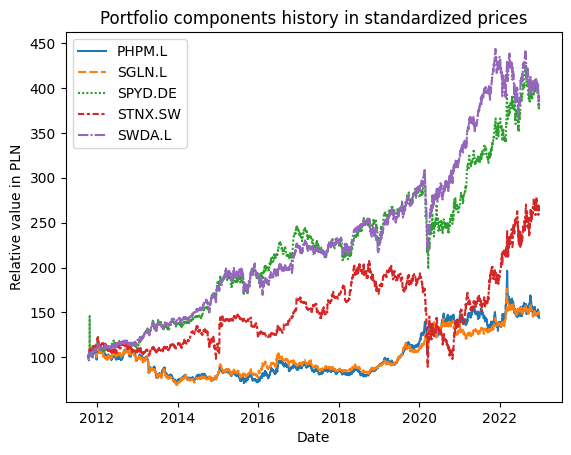

In [45]:
plot = sns.lineplot(data = etf_df)
plot.set(
    title = "Portfolio components history in standardized prices",
    xlabel = "Date",
    ylabel = "Relative value in PLN")

## Evaluation
Not it is time for the portfoli evaluation. First we need to convert the ratings into daily percentage changes.

In [46]:
returns_df = etf_df.pct_change()
returns_df

,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L
Date,,,,,
2011-10-14,NaN,NaN,NaN,NaN,NaN
2011-10-17,-0.005751,0.003112,-0.000512,0.003264,-0.007523
2011-10-18,-0.002324,-0.000927,0.014068,0.017484,0.016134
2011-10-19,0.005894,-0.007296,-0.004105,0.011974,0.002758
2011-10-20,-0.030961,-0.015676,-0.004815,-0.015771,-0.011114
...,...,...,...,...,...
2022-12-19,-0.004889,0.000719,0.000986,0.021518,-0.002203
2022-12-20,0.020187,0.013951,-0.007287,-0.002253,-0.003646
2022-12-21,-0.010557,0.003181,0.015688,0.017753,0.018878


The next step is to create the annualized covariance matrix.

In [47]:
covariance_matrix = risk_models.sample_cov(etf_df)
covariance_matrix

,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L
PHPM.L,0.048654,0.027842,0.008830,0.017535,0.010956
SGLN.L,0.027842,0.033386,0.001358,0.006218,0.010020
SPYD.DE,0.008830,0.001358,0.058396,0.022048,0.024354
STNX.SW,0.017535,0.006218,0.022048,0.071430,0.019122
SWDA.L,0.010956,0.010020,0.024354,0.019122,0.031211


Now we assign weights to the stocks.

In [48]:
weights = np.array([.0, .5, 0, 0, .5])

Now we calculate the variance of the specified portfolio.

In [49]:
portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
portfolio_variance

0.021159234812035837

Now we calculate the volatility (standard deviation) of the specified portfolio.

In [50]:
portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_volatility

0.14546214219526618

Now we calculate the expected annual return from the portfolio.

In [51]:
portfolio_simple_annual_return = (np.sum(returns_df.mean() * weights) + 1) ** 252 - 1
portfolio_simple_annual_return

0.1011163932305359

Show the expected annual return and volatility (risk, standard deviation).

In [52]:
print("Expected annual return: {:.2%}".format(portfolio_simple_annual_return))
print("Expected annual volatility: {:.2%}".format(portfolio_volatility))

Expected annual return: 10.11%
Expected annual volatility: 14.55%


## Portfolio optimisation
Calculate the expected returns and the annualised sample covariance matrix of asset returns

In [53]:
mean_historical_returns = expected_returns.mean_historical_return(etf_df)

Optimize for max Sharpe ratio

In [54]:
ef = EfficientFrontier(mean_historical_returns, covariance_matrix)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('PHPM.L', 0.0), ('SGLN.L', 0.0), ('SPYD.DE', 0.15468), ('STNX.SW', 0.012), ('SWDA.L', 0.83333)])
Expected annual return: 13.2%
Annual volatility: 17.3%
Sharpe Ratio: 0.65


(0.1320393526026195, 0.1726953033784913, 0.6487689613484514)

Get the discrete allocation of each share per stock

In [58]:
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value = 50000)

allocation, leftover = da.lp_portfolio()
print("Discrete Allocation:", allocation)
print("Funds Remaining: {:.2f} zł".format(leftover))

OptimizationError: ('Please check your objectives/constraints or use a different solver.', 'Please try greedy_portfolio')